In [126]:
import random
import time
from random import randrange
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [127]:
train_data = CIFAR10('./CIFAR10',train=True,transform=transforms.ToTensor(),download=True)
test_data = CIFAR10('./CIFAR10',train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [128]:
X_train = train_data.data.astype('float')
y_train = np.array(train_data.targets)

X_test = test_data.data.astype('float')
y_test = np.array(test_data.targets)

In [129]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


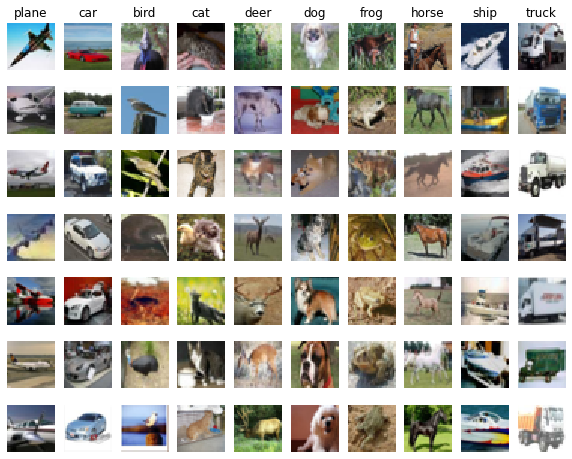

In [130]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y,cls in enumerate(classes):
  idxs = np.flatnonzero(y_train==y)
  idxs = np.random.choice(idxs,samples_per_class,replace=False)

  for i,idx in enumerate(idxs):
    plt_idx = num_classes*i+y+1
    plt.subplot(samples_per_class,num_classes,plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')

    if i==0:
      plt.title(cls)

plt.show()   

In [131]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training,num_dev,replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [133]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_dev = X_dev.reshape(X_dev.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


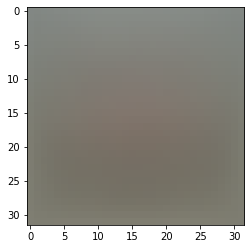

In [134]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.show()

In [135]:
X_train -=mean_image
X_val -= mean_image
X_dev -= mean_image
X_test -= mean_image

In [136]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.

X_train = np.hstack([X_train,np.ones((X_train.shape[0],1))])
X_val = np.hstack([X_val,np.ones((X_val.shape[0],1))])
X_dev = np.hstack([X_dev,np.ones((X_dev.shape[0],1))])
X_test = np.hstack([X_test,np.ones((X_test.shape[0],1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        dW[:,y[i]] -= X[i]
        dW[:,j] += X[i]
  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW += 2*reg*W
  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################
  
  

  return loss, dW

In [ ]:
W = np.random.randn(3073,10)*0.0001
loss,grad = svm_loss_naive(W,X_dev,y_dev,0.000005)
print('loss: %f'%loss)

loss: 9.251426


In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


In [ ]:
X = X_dev
y = y_dev
score = X.dot(W)

correct_score = score[range(X.shape[0]),y]
print(score.shape)
print(correct_score.shape)

(score[0][y[0]],correct_score[0])

(500, 10)
(500,)


(0.02598715130234109, 0.02598715130234109)

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.604415 analytic: 4.604415, relative error: 5.772051e-11
numerical: 11.311054 analytic: 11.332233, relative error: 9.353622e-04
numerical: 7.147347 analytic: 7.147347, relative error: 4.105380e-11
numerical: 8.666105 analytic: 8.657610, relative error: 4.903462e-04
numerical: 24.854403 analytic: 24.854403, relative error: 1.078519e-11
numerical: 2.558995 analytic: 2.558995, relative error: 4.028178e-11
numerical: -2.454902 analytic: -2.454902, relative error: 2.326620e-10
numerical: -12.269818 analytic: -12.269818, relative error: 4.452185e-11
numerical: 9.465019 analytic: 9.465019, relative error: 4.741737e-11
numerical: 10.750511 analytic: 10.750511, relative error: 4.019473e-11
numerical: 26.779927 analytic: 26.779927, relative error: 4.022219e-12
numerical: -0.415170 analytic: -0.470532, relative error: 6.250706e-02
numerical: 24.728858 analytic: 24.728858, relative error: 4.250451e-12
numerical: -13.419841 analytic: -13.419841, relative error: 2.428072e-11
numerical: -

In [ ]:
def check_gradient(W,X,y,origin_loss):
  step = 0.000001
  w,h = W.shape[0], W.shape[1]

  dw = np.zero_like(W)
  for i in range(w):
    for j in range(h):
      W_add_step = W
      W_add_step[i][j]+=step

      loss,_ = svm_loss_naive(W,X,y,0.000005)
      dw[i,j] = (loss - origin_loss) / step

  return dw

In [66]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  num_train = X.shape[0]
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  score = X.dot(W) #num_train * num_class
  correct_score = score[range(num_train),y]#num_train * 1

  margin = np.maximum(0,score - correct_score.reshape(num_train,1) + 1)
  margin[range(num_train),y] = 0 
  loss = np.sum(margin) / num_train + reg*np.sum(W*W)

  margin[margin != 0] = 1
  margin[range(X.shape[0]),y] = -np.sum(margin,axis=1)

  dW = (X.T.dot(margin) / num_train) + 2*reg*W
  
  return loss, dW


In [67]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
loss, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

print(loss)
# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.111982s
Vectorized loss and gradient: computed in 0.011425s
9.251426081236838
difference: 0.000000


In [116]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      idxs = np.random.choice(num_train, batch_size)
      X_batch = X[idxs]
      y_batch = y[idxs]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W -= learning_rate * grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ########################################################################### )
    y_pred = X.dot(self.W).argmax(axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


In [117]:
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [118]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 781.826408
iteration 100 / 1500: loss 285.927233
iteration 200 / 1500: loss 107.211030
iteration 300 / 1500: loss 42.955636
iteration 400 / 1500: loss 18.732507
iteration 500 / 1500: loss 10.253209
iteration 600 / 1500: loss 7.686137
iteration 700 / 1500: loss 6.338460
iteration 800 / 1500: loss 5.516075
iteration 900 / 1500: loss 5.562418
iteration 1000 / 1500: loss 5.294802
iteration 1100 / 1500: loss 5.243398
iteration 1200 / 1500: loss 5.236317
iteration 1300 / 1500: loss 5.530721
iteration 1400 / 1500: loss 5.430882
That took 9.163910s


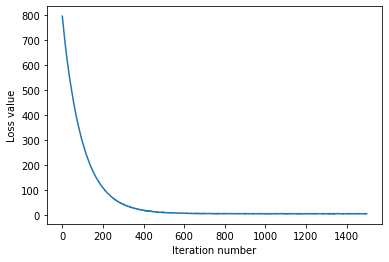

In [99]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [139]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print(y_train_pred.shape)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

(49000,)
training accuracy: 0.367531
validation accuracy: 0.372000


In [143]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learning_rate in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    num_iters = 1500

    svm.train(X_train,y_train,batch_size=200, learning_rate=learning_rate, 
              reg=reg, verbose=True, num_iters=num_iters)
    y_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_pred==y_train)

    y_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_pred==y_val)

    results[(learning_rate,reg)] = (train_accuracy,val_accuracy)

    if best_val < val_accuracy:
      best_val = val_accuracy
      best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 799.954092
iteration 100 / 1500: loss 291.824430
iteration 200 / 1500: loss 108.811040
iteration 300 / 1500: loss 43.360754
iteration 400 / 1500: loss 19.256145
iteration 500 / 1500: loss 9.995943
iteration 600 / 1500: loss 6.857334
iteration 700 / 1500: loss 5.894568
iteration 800 / 1500: loss 6.619643
iteration 900 / 1500: loss 5.932033
iteration 1000 / 1500: loss 4.893963
iteration 1100 / 1500: loss 5.180663
iteration 1200 / 1500: loss 5.423593
iteration 1300 / 1500: loss 5.432176
iteration 1400 / 1500: loss 5.297672
iteration 0 / 1500: loss 1562.501837
iteration 100 / 1500: loss 211.770647
iteration 200 / 1500: loss 32.544035
iteration 300 / 1500: loss 9.160453
iteration 400 / 1500: loss 5.736580
iteration 500 / 1500: loss 5.810104
iteration 600 / 1500: loss 5.659209
iteration 700 / 1500: loss 5.394171
iteration 800 / 1500: loss 5.001510
iteration 900 / 1500: loss 5.042270
iteration 1000 / 1500: loss 5.571995
iteration 1100 / 1500: loss 5.689685
iteration 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1561.834767
iteration 100 / 1500: loss 4277253216308501469344410961466461473455305952190578740436854370131524724179839085424208487516839917843436567158290217172992.000000
iteration 200 / 1500: loss 11044936596359465574208041984722074082115868106019283654546440022863027804254923792420277594055476115651805002095605086947207754617920924624284152911148529077760432431079284589822430256640815956240437958756162846050791581222960530602636966100992.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in subtract


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367796 val accuracy: 0.383000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.356245 val accuracy: 0.354000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.073184 val accuracy: 0.071000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.383000


In [144]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


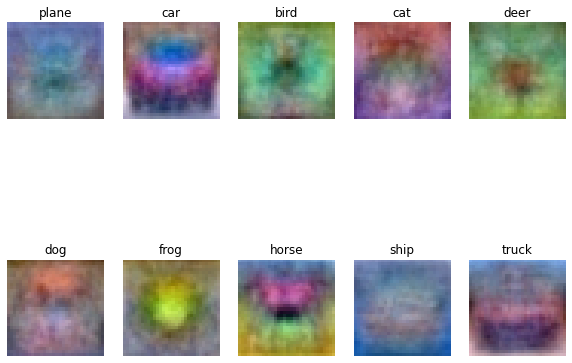

In [146]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(classes[i]) 
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')